In [37]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Plot the raw unprocessed data to see the performance trends of
- data collecting policy
- the evaluation policy in the future

## NOTE: Update the path variables based on the project location on your local machine.

In [38]:
info = {
'MountainCar' :{
                'path' : 'C:\\Users\\yashc\\Projects\\Control-NSDP\\Experiments_2\\MountainCar\\ActorCritic\\DataDefault\\0\\Results\\',
                'alpha': 0.5,
                'hyper':{
                        'zs':2,
                        'p_frac':0.2,
                        'weight_decay':1e-2,
                        'lr':1e-4,
                        'split':0},
                },
'MEDEVAC' :{
                'path' : 'C:\\Users\\yashc\\Projects\\Control-NSDP\\Experiments_2\\MEDEVAC\\ActorCritic\\DataDefault\\0\\Results\\',
                'alpha': 0.5,
                'hyper':{
                        'zs':2,
                        'p_frac':0.2,
                        'weight_decay':1e-2,
                        'lr':1e-4,
                        'split':0},
                },
'Diabetes' :{
                'path' : 'C:\\Users\\yashc\\Projects\\Control-NSDP\\Experiments_2\\SimGlucosediscreteNS-v0\\ActorCritic\\DataDefault\\0\\Results\\',
                'alpha': 0.5,
                'hyper': {
                        'zs':2,
                        'p_frac':0.2,
                        'weight_decay':1e-2,
                        'lr':1e-4,
                        'split':0},
                },


'RoboToy-Passive' :{
                'path' : 'C:\\Users\\yashc\\Projects\\Control-NSDP\\Experiments_2\\RoboToy\\ActorCritic\\DataDefault\\0\\Results\\passive_',
                'alpha': 'x',
                'hyper' : {
                        'zs':2,
                        'p_frac':0.2, 
                        'weight_decay':1e-2,
                        'lr':1e-4,
                        'split':0.2},
            },


'RoboToy-Active' :{
                'path' : 'C:\\Users\\yashc\\Projects\\Control-NSDP\\Experiments_2\\RoboToy\\ActorCritic\\DataDefault\\0\\Results\\active_',
                'alpha': 'x',
                'hyper': {
                        'zs':2,
                        'p_frac':0.2,
                        'weight_decay':1e-2,
                        'lr':1e-3,
                        'split':0},
            },
}

# domain = 'MountainCar'
# domain = 'RoboToy-Passive'
# domain = 'RoboToy-Active'
# domain = 'Diabetes'
domain = 'MEDEVAC'


Basic Ground Truth Plots

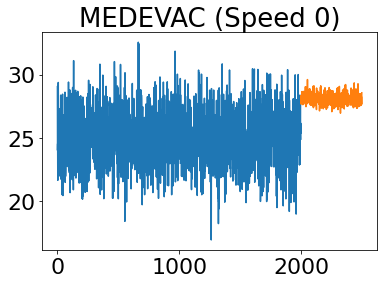

Maximum G:  90.86034917024938


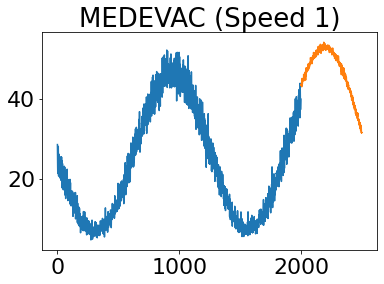

Maximum G:  98.29850818000646


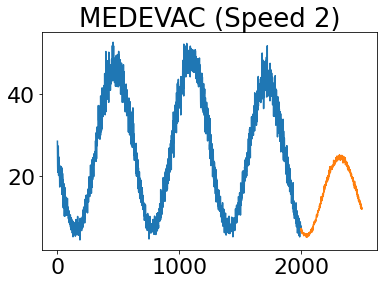

Maximum G:  98.29850818000646


In [39]:

path, alpha, hyper = info[domain]['path'], info[domain]['alpha'], info[domain]['hyper'] 

seeds = 30
speeds = (0,1,2)

max_G = -9999

for speed in speeds:
    plt.figure()
    betas = None
    evals = None
    for seed in range(seeds):
        beta_perfs = np.load('{}beta_rho_data_{}_{}_{}.npy'.format(path, speed, alpha, seed))
        eval_perfs = np.load('{}eval_data_{}_{}_{}.npy'.format(path, speed, alpha, seed))

        # [episode_number, episode length, (rho, reward)]
        returns = np.sum(beta_perfs[:,:,1], axis=1)

        max_return = np.max(np.abs(returns))
        if max_return > max_G:
            max_G = max_return

        # Accumulate over all the data across seeds
        if betas is None:
            betas = returns
            evals = eval_perfs
        else:
            betas += returns
            evals += eval_perfs

    # Plot the average across seeds
    xs_beta = np.arange(len(betas))
    xs_eval = np.arange(len(betas), len(betas)+len(evals))

    plt.plot(xs_beta, betas/seeds)
    if domain == 'Diabetes':
        # Rescaling Use for Diabetes as only 1/30 got future eval run got executed and got averaged. 
        plt.plot(xs_eval, evals*30/seeds) 
    else:
        plt.plot(xs_eval, evals/seeds)
    
    plt.title('{} (Speed {})'.format(domain, speed))
    plt.savefig('{}_{}_base.png'.format(domain, speed), bbox_inches="tight")
    plt.show()

    print("Maximum G: ", max_G)

Comparitive plots for different baseline methods (Avergaed over all seeds/ Useful for BIAS analysis)
- OPEN: Proposed Passive/Active/Hybrid non-stationarity method 
- WLS: Baseline method to handle passive non-stationarity
- WIS: Baseline method designed for stationary settings 
- SWIS: Baseline method that uses WIS with sliding window (data from last p episodes)

In [40]:
import os,sys
sys.path.insert(1, os.path.join(os.getcwd()  , '../..'))

from Src.OPE.hybrid import Naive, OPEN_1, OPEN_2
from Src.OPE.passive import WLS
from Src.OPE.stationary import WIS

path, alpha = info[domain]['path'], info[domain]['alpha']
seeds = 30

analysis_dict = {}
for speed in speeds:

    beta_perfs = np.load('{}beta_rho_data_{}_{}_{}.npy'.format(path, speed, alpha, 0))
    eval_perfs = np.load('{}eval_data_{}_{}_{}.npy'.format(path, speed, alpha, 0))

    N = beta_perfs.shape[0]
    k = 200 #eval_perfs.shape[0]
    p = int(hyper['p_frac']*N)
    
    # Initialize all the arrays
    beta_ar     = np.zeros((seeds, N))
    eval_ar     = np.zeros((seeds, k))
    OPEN_ar_past= np.zeros((seeds, N-p))        # Predictions of past time steps
    OPEN_ar     = np.zeros_like(eval_ar)        # Predictions for the future steps
    OPEN_p_ar   = np.zeros_like(eval_ar)        # Predictions using the passive version of OPEN
    WLS_ar      = np.zeros_like(eval_ar)
    WIS_ar      = np.zeros_like(eval_ar)
    SWIS_ar     = np.zeros_like(eval_ar)

    for seed in range(seeds):
        # Behavior policy's performances
        beta_perfs = np.load('{}beta_rho_data_{}_{}_{}.npy'.format(path, speed, alpha, seed))
        beta_ar[seed, :] = np.sum(beta_perfs[:,:,1], axis=1) / max_G

        # True future performance of the evaluation policy 
        eval_ar[seed, :] = np.load('{}eval_data_{}_{}_{}.npy'.format(path, speed, alpha, seed))[:k] / max_G

        # Forecast using Proposed OPEN method
        OPEN_obj = OPEN_2(hyper=hyper, p=p, norm=max_G) 
        OPEN_ar[seed, :], OPEN_ar_past[seed, :] = OPEN_obj.predict(beta_perfs, k, past=True)

        # Forecast using Passive baseline method WLS
        WLS_obj = WLS(p=5, norm=max_G) 
        WLS_ar[seed, :] = WLS_obj.predict(beta_perfs, k)

        # Forecast using stationary baseline method WIS
        WIS_obj = WIS(norm=max_G) 
        WIS_ar[seed, :] = WIS_obj.predict(beta_perfs, k)

        # Forecast using stationary baseline method WIS
        SWIS_obj = WIS(p=p, norm=max_G) 
        SWIS_ar[seed, :] = SWIS_obj.predict(beta_perfs, k)


    print('Speed {}'.format(speed))
    analysis_dict[speed] = (beta_ar, eval_ar, OPEN_ar, OPEN_ar_past, OPEN_p_ar, WLS_ar, WIS_ar, SWIS_ar)

np.save('{}_analysis'.format(domain), analysis_dict)


Speed 0
Speed 1
Speed 2


Plot all the results

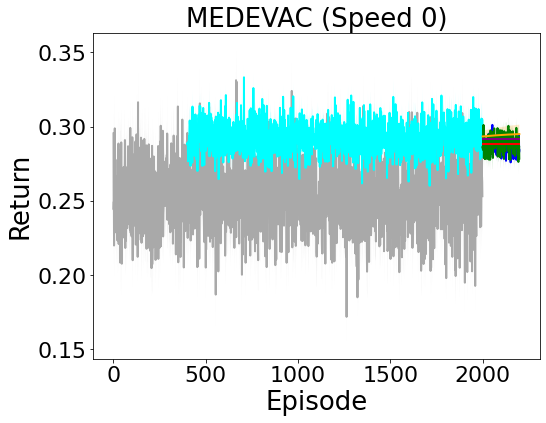

<Figure size 576x72 with 0 Axes>

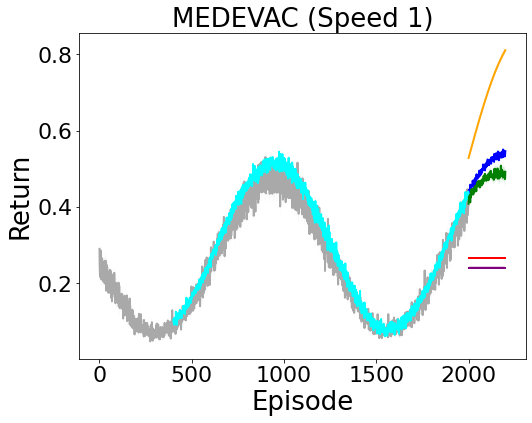

<Figure size 576x72 with 0 Axes>

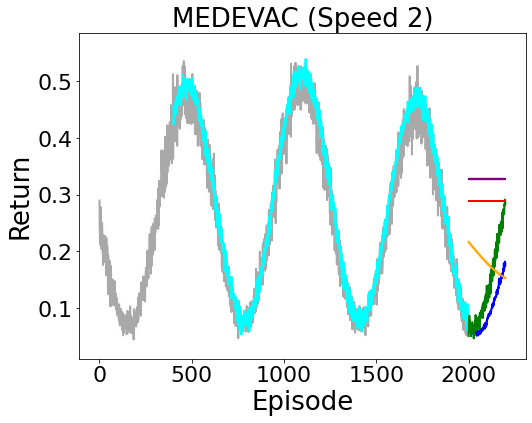

<Figure size 576x72 with 0 Axes>

In [41]:
analysis_dict = np.load('{}_analysis.npy'.format(domain), allow_pickle=True).item()

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

import matplotlib as mpl

# mpl.style.use('seaborn')  # https://matplotlib.org/users/style_sheets.html

plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
mpl.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

######################
# Entire curve PLOTS #
######################

def average_plot(xs, ys, ax_handle, color, linewidth=2, alpha=0.2, label="", special=False):
    if special:
        mu, stderr = np.abs(np.mean(ys, axis=0)), np.std(ys, axis=0)/np.sqrt(ys.shape[0])
    else:
        mu, stderr = np.mean(ys, axis=0), np.std(ys, axis=0)/np.sqrt(ys.shape[0])
    if label != "":
        ax_handle.plot(xs, mu, label=label, c=color, linewidth=linewidth)
    else:
        ax_handle.plot(xs, mu, c=color, linewidth=linewidth)    
    ax_handle.fill_between(xs, mu - stderr, mu + stderr, alpha=alpha, facecolor=color)



# MSE, MSE-err, Bias, variance
mse_open, mse_open_p = np.zeros((len(speeds), 4)), np.zeros((len(speeds), 4))
mse_wls, mse_wis, mse_swis = np.zeros((len(speeds), 4)), np.zeros((len(speeds), 4)), np.zeros((len(speeds), 4))

for speed in speeds:
    beta_ar, eval_ar, OPEN_ar, OPEN_ar_past, OPEN_p_ar, WLS_ar, WIS_ar, SWIS_ar = analysis_dict[speed]

    if domain == 'Diabetes':
        eval_ar = eval_ar*30 # Rescaling Use for Diabetes as only 1/30 got eval run got executed and got averaged. 
    
    # Store MSE/bias/variance
    temp = np.mean(OPEN_ar, axis=1) - np.mean(eval_ar, axis=1) # [Seeds, future] -> [Seeds]
    mse_open[speed] = [np.mean(temp**2), np.std(temp**2)/np.sqrt(len(temp)), np.mean(temp), np.std(np.mean(OPEN_ar, axis=1))**2]

    temp = np.mean(OPEN_p_ar, axis=1) - np.mean(eval_ar, axis=1) # [Seeds, future] -> [Seeds]
    mse_open_p[speed] = [np.mean(temp**2), np.std(temp**2)/np.sqrt(len(temp)), np.mean(temp), np.std(np.mean(OPEN_p_ar, axis=1))**2]

    temp = np.mean(WLS_ar, axis=1) - np.mean(eval_ar, axis=1) # [Seeds, future] -> [Seeds]
    mse_wls[speed] = [np.mean(temp**2), np.std(temp**2)/np.sqrt(len(temp)), np.mean(temp), np.std(np.mean(WLS_ar, axis=1))**2]

    temp = np.mean(WIS_ar, axis=1) - np.mean(eval_ar, axis=1) # [Seeds, future] -> [Seeds]
    mse_wis[speed] = [np.mean(temp**2), np.std(temp**2)/np.sqrt(len(temp)), np.mean(temp), np.std(np.mean(WIS_ar, axis=1))**2]

    temp = np.mean(SWIS_ar, axis=1) - np.mean(eval_ar, axis=1) # [Seeds, future] -> [Seeds]
    mse_swis[speed] = [np.mean(temp**2), np.std(temp**2)/np.sqrt(len(temp)), np.mean(temp), np.std(np.mean(SWIS_ar, axis=1))**2]

    # Plot the average across seeds
    N, k, Np = beta_ar.shape[1], eval_ar.shape[1], OPEN_ar_past.shape[1]
    xs_beta = np.arange(N)
    xs_eval = np.arange(N, N+k)

    fig1 = plt.figure(figsize=(8, 6))
    ax1 = fig1.add_subplot(1, 1, 1)
    average_plot(xs_beta, beta_ar, ax1, color='darkgray', label='Observed')
    average_plot(xs_eval, eval_ar, ax1, color='blue', label='True')
    average_plot(xs_beta[-Np:], OPEN_ar_past, ax1, color='cyan', label='OPEN_past')
    average_plot(xs_eval, OPEN_ar, ax1, color='green', label='OPEN (proposed)')
    average_plot(xs_eval, WLS_ar, ax1, color='orange', label='Pro-WLS')
    average_plot(xs_eval, WIS_ar, ax1, color='red', label='WIS')
    average_plot(xs_eval, SWIS_ar, ax1, color='purple', label='SWIS')

    ax1.set_xlabel('Episode')#, fontweight ='bold', fontsize = 15)
    ax1.set_ylabel('Return')#, fontweight ='bold', fontsize = 15)
    # plt.legend(loc=2)
    ax1.set_title('{} (Speed {})'.format(domain, speed))
    fig1.savefig('{}_{}_curve.png'.format(domain, speed), bbox_inches="tight")

    figLegend1 = plt.figure(figsize=(8, 1))
    l1 = plt.figlegend(*ax1.get_legend_handles_labels(), loc='upper center', fancybox=True, shadow=True, ncol=3)
    for line in l1.get_lines():
        line.set_linewidth(5.0)
    figLegend1.savefig('curve_legend.png', bbox_inches="tight")
    plt.show()
    


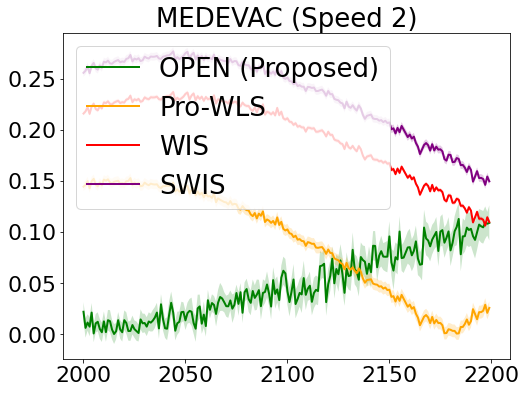

In [42]:

    ##############
    # Bias PLOTS #
    ##############

    plt.figure(figsize=(8, 6))
    average_plot(xs_eval, OPEN_ar - np.mean(eval_ar, axis=0), plt, color='green', label='OPEN (Proposed)', special=True)
    average_plot(xs_eval, WLS_ar - np.mean(eval_ar, axis=0), plt, color='orange', label='Pro-WLS', special=True)
    average_plot(xs_eval, WIS_ar - np.mean(eval_ar, axis=0), plt, color='red', label='WIS', special=True)
    average_plot(xs_eval, SWIS_ar - np.mean(eval_ar, axis=0), plt, color='purple', label='SWIS', special=True)

    # plt.ylim([-100, 100])
    plt.legend(loc=2)
    plt.title('{} (Speed {})'.format(domain, speed))
    plt.savefig('{}_{}_bias.png'.format(domain, speed), bbox_inches="tight")
    plt.show()




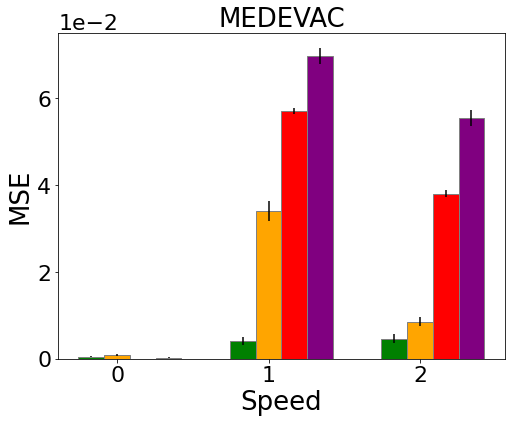

<Figure size 576x36 with 0 Axes>

In [43]:


#############
# MSE PLOTS #
#############
barWidth = 0.17
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
 
# Set position of bar on X axis
br1 = np.arange(len(mse_open))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
 
# Make the plot
ax1.bar(br1, mse_open[:, 0], yerr=mse_open[:, 1], color ='green', width = barWidth, 
        edgecolor ='grey', label ='OPEN (Proposed)')
ax1.bar(br2, mse_wls[:, 0], yerr=mse_wls[:, 1], color ='orange', width = barWidth,
        edgecolor ='grey', label ='Pro-WLS')
ax1.bar(br3, mse_wis[:, 0], yerr=mse_wis[:, 1], color ='red', width = barWidth,
        edgecolor ='grey', label ='WIS')
ax1.bar(br4, mse_swis[:, 0], yerr=mse_swis[:, 1], color ='purple', width = barWidth, 
        edgecolor ='grey', label ='SWIS')
        
# Adding Xticks
ax1.set_xlabel('Speed')#, fontweight ='bold', fontsize = 15)
ax1.set_ylabel('MSE')#, fontweight ='bold', fontsize = 15)
ax1.set_xticks([r + barWidth for r in range(len(mse_open))])
ax1.set_xticklabels(['0', '1', '2'])
 
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax1.set_ylim([0, 0.015])
# ax1.legend(loc=2)
ax1.set_title('{}'.format(domain, speed))
fig.savefig('{}_MSE.png'.format(domain), bbox_inches="tight")
plt.show()

figLegend1 = plt.figure(figsize=(8, 0.5))
l1 = plt.figlegend(*ax1.get_legend_handles_labels(), loc='upper center', fancybox=True, shadow=True, ncol=4)
for line in l1.get_lines():
        line.set_linewidth(5.0)
figLegend1.savefig('MSE_legend.png', bbox_inches="tight")
plt.show()


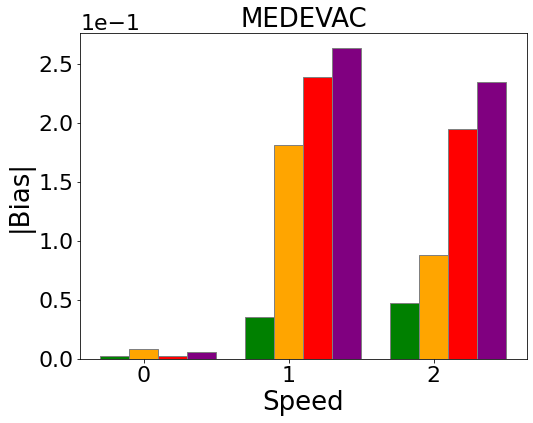

In [44]:


#############
# Bias PLOTS #
#############
barWidth = 0.2
fig = plt.subplots(figsize=(8, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(mse_open))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
 
# Make the plot
plt.bar(br1, np.abs(mse_open[:, 2]), color ='green', width = barWidth, 
        edgecolor ='grey', label ='OPEN')
plt.bar(br2, np.abs(mse_wls[:, 2]), color ='orange', width = barWidth,
        edgecolor ='grey', label ='WLS')
plt.bar(br3, np.abs(mse_wis[:, 2]), color ='red', width = barWidth,
        edgecolor ='grey', label ='WIS')
plt.bar(br4, np.abs(mse_swis[:, 2]), color ='purple', width = barWidth,
        edgecolor ='grey', label ='SWIS')
 
# Adding Xticks
plt.xlabel('Speed')#, fontweight ='bold', fontsize = 15)
plt.ylabel('|Bias|')#, fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(mse_open))],
        ['0', '1', '2'])
# plt.ylim([0, 0.15]) 
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# plt.legend(loc=2)
plt.title('{}'.format(domain, speed))
plt.savefig('{}_bias.png'.format(domain), bbox_inches="tight")
plt.show()



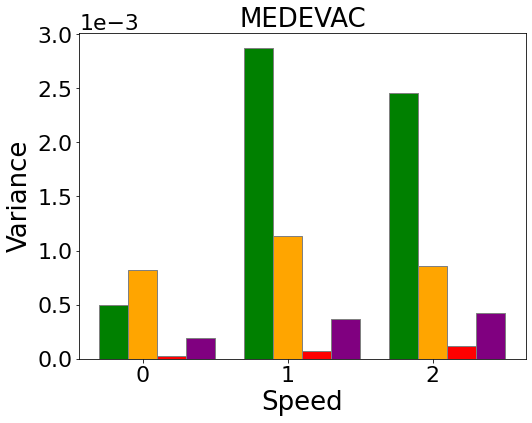

In [45]:


#############
# Variance PLOTS #
#############
barWidth = 0.2
fig = plt.subplots(figsize=(8, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(mse_open))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
 
# Make the plot
plt.bar(br1, mse_open[:, 3], color ='green', width = barWidth, 
        edgecolor ='grey', label ='OPEN')
plt.bar(br2, mse_wls[:, 3], color ='orange', width = barWidth,
        edgecolor ='grey', label ='WLS')
plt.bar(br3, mse_wis[:, 3], color ='red', width = barWidth,
        edgecolor ='grey', label ='WIS')
plt.bar(br4, mse_swis[:, 3], color ='purple', width = barWidth,
        edgecolor ='grey', label ='SWIS')
 
# Adding Xticks
plt.xlabel('Speed')#, fontweight ='bold', fontsize = 15)
plt.ylabel('Variance')#, fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(mse_open))],
        ['0', '1', '2'])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
 
# plt.legend(loc=2)
plt.title('{}'.format(domain, speed))
plt.savefig('{}_var.png'.format(domain), bbox_inches="tight")
plt.show()